# Evaluating Models and Classified Datasets

In this workbook, I will be evaluating 2 base models, and the 3 classified datasets. The end goal is to identify which model and dataset has the best accuracy, loss, with little missclassification. 

After selecting the model and dataset, we will proceed to optimize the model in the next workbook.

In [ ]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
import sklearn
import itertools

from google.colab.patches import cv2_imshow
from google.colab import files
from skimage import io
from PIL import Image

import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [ ]:
!tar -xvf "/content/drive/MyDrive/Colab Notebooks/dataset/UTKFace.tar" -C "/content"     #[run this cell to extract tar files]

Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [ ]:
df_images = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataframe/image_classes_summary.csv')
df_images['age_bin10_class'].value_counts().sort_index()

0    3062
1    1531
2    7344
3    4537
4    2245
5    2299
6    1318
7     699
8     504
9     169
Name: age_bin10_class, dtype: int64

# Base CNN Model

This base CNN Model was chosen with reference to this [author](https://) whom performed a reasonable accuracy on image datasets. This is to get an initial benchmark on the model's performance with the different datasets and different techniques to see if it improves. 

## CNN with Size Bin10 Class (grayscale images)

We will explore the Base CNN Model with the Size Bin10 Class dataset

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_bin10_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0    2143
1    1072
2    5141
3    3176
4    1571
5    1609
6     923
7     489
8     353
9     118
Name: age_bin10_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.129200
1    0.064530
2    0.309715
3    0.191340
4    0.094756
5    0.097005
6    0.055532
7    0.029523
8    0.021229
9    0.007170
Name: age_bin10_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
16216,/content/UTKFace/1_1_2_20161219203318222.jpg.c...,1
14501,/content/UTKFace/10_0_0_20170110224500062.jpg....,10
2573,/content/UTKFace/25_1_4_20161221193646742.jpg....,25
17687,/content/UTKFace/2_0_4_20161221192650388.jpg.c...,2
553,/content/UTKFace/36_1_0_20170105183405999.jpg....,36


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 10

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

bin10_cnn_1 = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
bin10_cnn_1.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
bin10_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
bin10_cnn_1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
bin10_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

bin10_cnn_1.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
bin10_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

bin10_cnn_1.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
bin10_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
bin10_cnn_1.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
bin10_cnn_1.add(Dense(132, activation='relu'))

# Output layer with 10 nodes (equal to the no. of classes).
bin10_cnn_1.add(Dense(10, activation='softmax'))

bin10_cnn_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
average_pooling2d_13 (Averag (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
average_pooling2d_14 (Averag (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 21, 21, 256)      

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Compiling the above created CNN architecture.

bin10_cnn_1.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
    )

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the above created CNN model.

bin10_cnn_1_history = bin10_cnn_1.fit(train_dataset,
                                  batch_size=256,
                                  validation_data=test_dataset,
                                  epochs=30,
                                  callbacks=[early_stop],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/30
65/65 [==============================] - 12s 181ms/step - loss: 2.9607 - accuracy: 0.2851 - val_loss: 1.9320 - val_accuracy: 0.3097
Epoch 2/30
65/65 [==============================] - 12s 179ms/step - loss: 1.8918 - accuracy: 0.3331 - val_loss: 1.8706 - val_accuracy: 0.3473
Epoch 3/30
65/65 [==============================] - 12s 178ms/step - loss: 1.8695 - accuracy: 0.3456 - val_loss: 1.8395 - val_accuracy: 0.3547
Epoch 4/30
65/65 [==============================] - 12s 183ms/step - loss: 1.8523 - accuracy: 0.3478 - val_loss: 1.8227 - val_accuracy: 0.3578
Epoch 5/30
65/65 [==============================] - 12s 191ms/step - loss: 1.8059 - accuracy: 0.3606 - val_loss: 1.8009 - val_accuracy: 0.3629
Epoch 6/30
65/65 [==============================] - 13s 193ms/step - loss: 1.7817 - accuracy: 0.3646 - val_loss: 1.8234 - val_accuracy: 0.3249
Epoch 7/30
65/65 [==============================] - 12s 191ms/step - loss: 1.7655 - accuracy: 0.3661 - val_loss: 1.7346 - val_accuracy: 0.3689

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = bin10_cnn_1_history.history['loss']
test_loss = bin10_cnn_1_history.history['val_loss']
train_accuracy = bin10_cnn_1_history.history['accuracy']
test_accuracy = bin10_cnn_1_history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

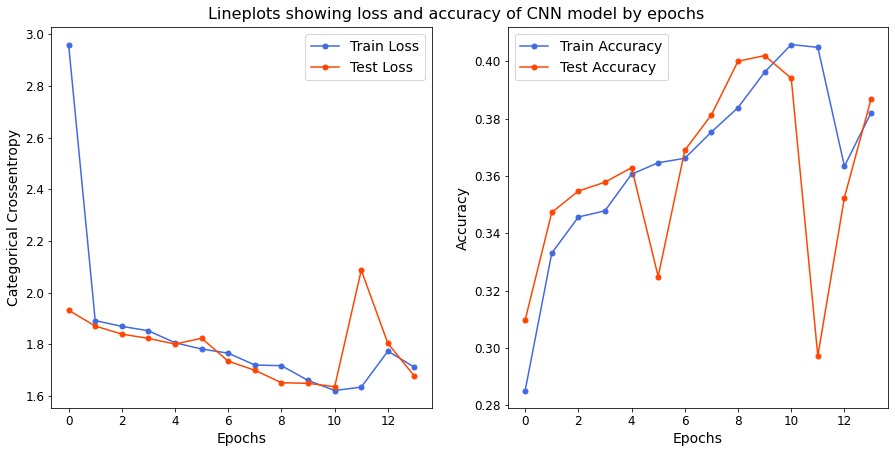

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

The observation here is there seems to be signs underfitting.

In [ ]:
# Evaluating the model on test dataset.

bin10_cnn_1_score = bin10_cnn_1.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 2s 73ms/step - loss: 1.6766 - accuracy: 0.3868


In [ ]:
# Printing the relevant score summary.

bin10_cnn_1_labels = bin10_cnn_1.metrics_names
print(f'CNN_1 model {bin10_cnn_1_labels[0]} \t= {round(bin10_cnn_1_score[0], 3)}')
print(f'CNN_1 model {bin10_cnn_1_labels[1]} \t= {round(bin10_cnn_1_score[1], 3)}')

CNN_1 model loss 	= 1.677
CNN_1 model accuracy 	= 0.387


In [ ]:
# Generating predictions from the model above.

bin10_cnn_1_pred = bin10_cnn_1.predict(test_dataset)
bin10_cnn_1_pred = bin10_cnn_1_pred.argmax(axis=-1)

In [ ]:
len(bin10_cnn_1_pred)

7113

In [ ]:
len(bin10_cnn_1_pred)

7113

In [ ]:
bin10_cnn_1_cm = confusion_matrix(test_labels_list, bin10_cnn_1_pred)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/images/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


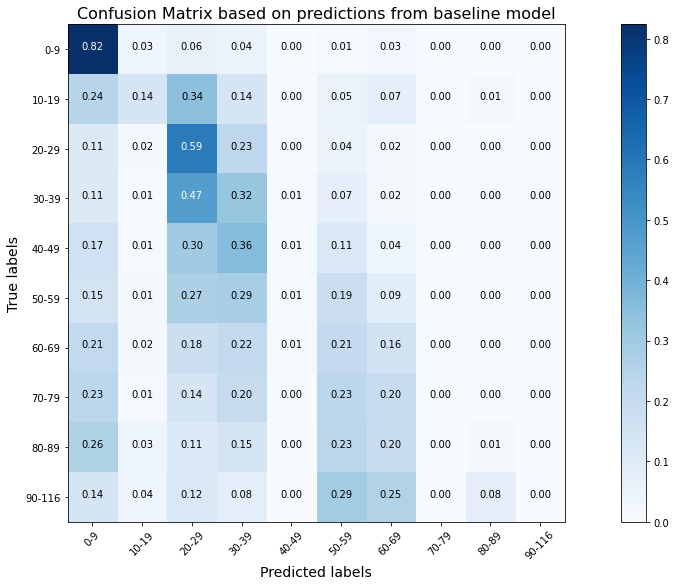

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bin10_cnn_1_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="bin10_cnn_1_cm"
                     )

plt.show()

## CNN with Size Bin10 Class (coloured images)

In [ ]:
# Creating tensorflow constants of filenames and labels for train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Redefining the function to read, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 1 to 3 changes the output images from grayscale to RGB coloured.

num_classes = 10

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
#train_dataset = train_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
train_dataset

<BatchDataset shapes: ((None, None, None, 3), (None, 10)), types: (tf.uint8, tf.float32)>

In [ ]:
# Defining the architecture of the sequential neural network.

bin10_cnn_2 = Sequential()

bin10_cnn_2.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(200, 200, 3)))    # 3rd dim = 3 for RGB coloured images.
bin10_cnn_2.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
bin10_cnn_2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
bin10_cnn_2.add(MaxPooling2D(pool_size=(2,2)))

bin10_cnn_2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
bin10_cnn_2.add(MaxPooling2D(pool_size=(2,2)))

bin10_cnn_2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
bin10_cnn_2.add(MaxPooling2D(pool_size=(2,2)))

bin10_cnn_2.add(GlobalAveragePooling2D())

bin10_cnn_2.add(Dense(20, activation='relu'))
bin10_cnn_2.add(Dense(10, activation='softmax'))

bin10_cnn_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 198, 198, 8)       224       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 196, 196, 16)      1168      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 194, 194, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 95, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# Compiling the neural network defined above.

bin10_cnn_2.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy'])

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the model.

bin10_cnn_2_history = bin10_cnn_2.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        epochs=30,
                        callbacks=[early_stop],
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 16s 231ms/step - loss: 2.4048 - accuracy: 0.2967 - val_loss: 1.9709 - val_accuracy: 0.2903
Epoch 2/30
65/65 [==============================] - 15s 229ms/step - loss: 1.9174 - accuracy: 0.3321 - val_loss: 1.8616 - val_accuracy: 0.3471
Epoch 3/30
65/65 [==============================] - 15s 228ms/step - loss: 1.8417 - accuracy: 0.3560 - val_loss: 1.8174 - val_accuracy: 0.3481
Epoch 4/30
65/65 [==============================] - 15s 229ms/step - loss: 1.7990 - accuracy: 0.3642 - val_loss: 1.7660 - val_accuracy: 0.3661
Epoch 5/30
65/65 [==============================] - 15s 230ms/step - loss: 1.7636 - accuracy: 0.3732 - val_loss: 1.7294 - val_accuracy: 0.3699
Epoch 6/30
65/65 [==============================] - 15s 229ms/step - loss: 1.7378 - accuracy: 0.3780 - val_loss: 1.7246 - val_accuracy: 0.3747
Epoch 7/30
65/65 [==============================] - 15s 229ms/step - loss: 1.6958 - accuracy: 0.3886 - val_loss: 1.6923 - val_accuracy: 0.3849

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss2 = bin10_cnn_2_history.history['loss']
test_loss2 = bin10_cnn_2_history.history['val_loss']
train_accuracy2 = bin10_cnn_2_history.history['accuracy']
test_accuracy2 = bin10_cnn_2_history.history['val_accuracy']

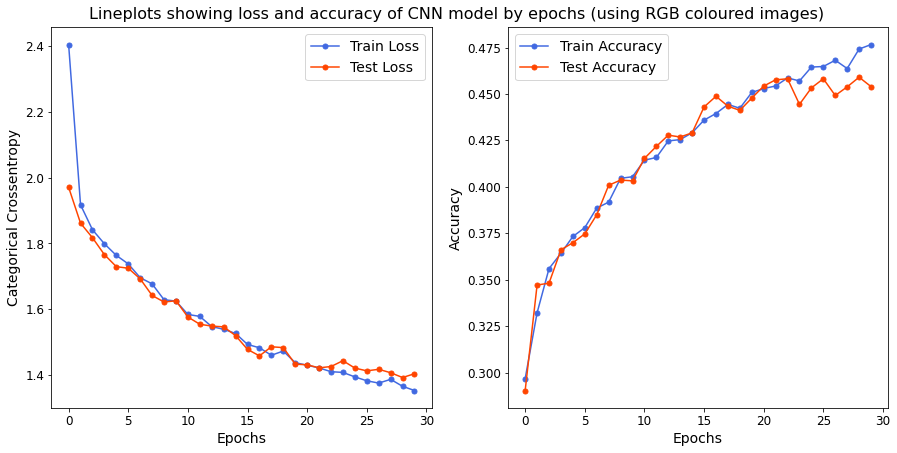

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss2, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss2, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy2, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy2, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs (using RGB coloured images)", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/bin10_cnn_2_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

bin10_cnn_2_score = bin10_cnn_2.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 2s 81ms/step - loss: 1.4037 - accuracy: 0.4540


In [ ]:
# Printing the relevant score summary.

bin10_cnn_2_labels = bin10_cnn_2.metrics_names

print(f'bin10_CNN_1 model {bin10_cnn_1_labels[0]} \t\t= {round(bin10_cnn_1_score[0], 3)}')
print(f'bin10_CNN_1 model {bin10_cnn_1_labels[1]} \t= {round(bin10_cnn_1_score[1], 3)}')
print()
print(f'bin10_CNN_2 model {bin10_cnn_2_labels[0]} \t\t= {round(bin10_cnn_2_score[0], 3)}')
print(f'bin10_CNN_2 model {bin10_cnn_2_labels[1]} \t= {round(bin10_cnn_2_score[1], 3)}')

bin10_CNN_1 model loss 		= 1.677
bin10_CNN_1 model accuracy 	= 0.387

bin10_CNN_2 model loss 		= 1.404
bin10_CNN_2 model accuracy 	= 0.454


In [ ]:
# Saving the model as a h5 file for possible use later.

bin10_cnn_2.save(f"/content/drive/My Drive/model/bin10_cnn_2_model_acc_{round(bin10_cnn_2_score[1], 3)}.h5", save_format='h5')

In [ ]:
# Generating predictions from the model above.

bin10_cnn_2_pred = bin10_cnn_2.predict(test_dataset)
bin10_cnn_2_pred = bin10_cnn_2_pred.argmax(axis=-1)

In [ ]:
len(bin10_cnn_2_pred)

7113

In [ ]:
len(bin10_cnn_2_pred)

7113

In [ ]:
bin10_cnn_2_cm = confusion_matrix(test_labels_list, bin10_cnn_2_pred)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/images/{export_as}.png', bbox_inches='tight');

Confusion matrix, without normalization


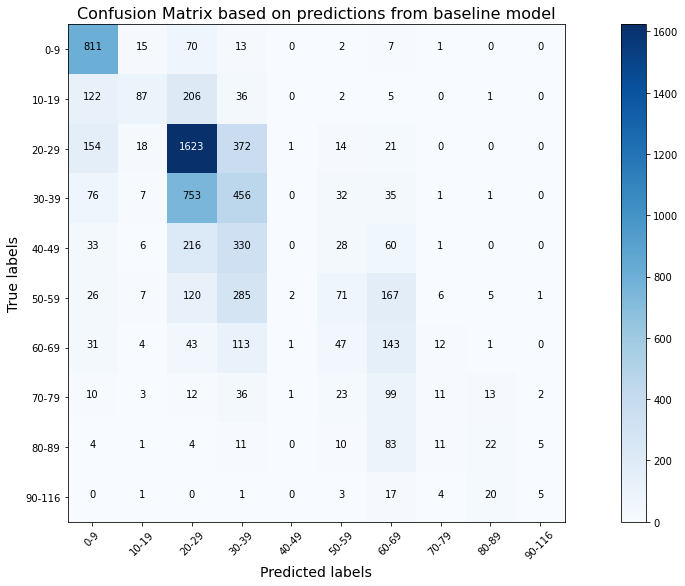

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bin10_cnn_2_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="bin10_cnn_2_cm"
                     )

plt.show()

In [ ]:
y_test.value_counts().sort_index()

0     919
1     459
2    2203
3    1361
4     674
5     690
6     395
7     210
8     151
9      51
Name: age_bin10_class, dtype: int64

In [ ]:
df_images['age_bin10_label'].value_counts()

30-39     7784
40-49     4339
0-9       3062
60-69     2211
50-59     2100
10-19     1531
70-79     1172
80-89      685
90-116     540
20-29      284
Name: age_bin10_label, dtype: int64

Normalized confusion matrix


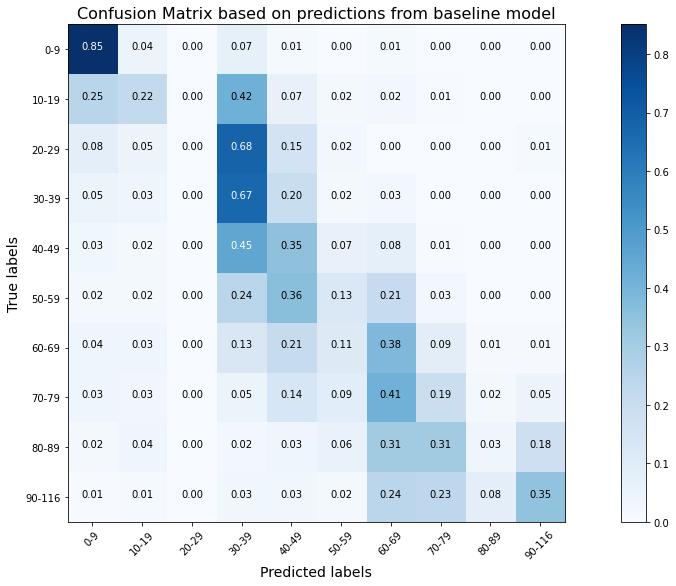

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bin10_cnn_2_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="bin10_cnn_2_cm"
                     )

plt.show()

## CNN with Balanced Class (grayscale images)

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_bal_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0    2389
1    2957
2    2611
3    3388
4    3572
5    1678
Name: age_bal_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.143962
1    0.178125
2    0.157318
3    0.204274
4    0.215240
5    0.101083
Name: age_bal_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
14303,/content/UTKFace/40_0_0_20170117134621935.jpg....,40
6075,/content/UTKFace/55_0_3_20170119205343062.jpg....,55
9634,/content/UTKFace/54_0_0_20170109012848473.jpg....,54
12156,/content/UTKFace/42_0_1_20170116205000015.jpg....,42
19249,/content/UTKFace/24_0_2_20170116161928019.jpg....,24


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 6

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

bal_cnn_1 = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
bal_cnn_1.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
bal_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
bal_cnn_1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
bal_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

bal_cnn_1.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
bal_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

bal_cnn_1.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
bal_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
bal_cnn_1.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
bal_cnn_1.add(Dense(132, activation='relu'))

# Output layer with 6 nodes (equal to the no. of classes).
bal_cnn_1.add(Dense(6, activation='softmax'))

bal_cnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 128)      0

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Compiling the above created CNN architecture.

bal_cnn_1.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
    )

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the above created CNN model.

bal_cnn_1_history = bal_cnn_1.fit(train_dataset,
                                  batch_size=256,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[early_stop],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/60
65/65 [==============================] - 32s 218ms/step - loss: 2.5373 - accuracy: 0.2225 - val_loss: 1.6780 - val_accuracy: 0.2893
Epoch 2/60
65/65 [==============================] - 12s 177ms/step - loss: 1.6419 - accuracy: 0.3026 - val_loss: 1.6108 - val_accuracy: 0.3239
Epoch 3/60
65/65 [==============================] - 12s 177ms/step - loss: 1.5953 - accuracy: 0.3276 - val_loss: 1.5575 - val_accuracy: 0.3412
Epoch 4/60
65/65 [==============================] - 12s 177ms/step - loss: 1.5648 - accuracy: 0.3411 - val_loss: 1.5109 - val_accuracy: 0.3664
Epoch 5/60
65/65 [==============================] - 11s 176ms/step - loss: 1.5241 - accuracy: 0.3617 - val_loss: 1.4717 - val_accuracy: 0.3827
Epoch 6/60
65/65 [==============================] - 12s 176ms/step - loss: 1.5044 - accuracy: 0.3732 - val_loss: 1.5513 - val_accuracy: 0.3526
Epoch 7/60
65/65 [==============================] - 12s 177ms/step - loss: 1.5054 - accuracy: 0.3647 - val_loss: 1.4282 - val_accuracy: 0.3929

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = bal_cnn_1_history.history['loss']
test_loss = bal_cnn_1_history.history['val_loss']
train_accuracy = bal_cnn_1_history.history['accuracy']
test_accuracy = bal_cnn_1_history.history['val_accuracy']

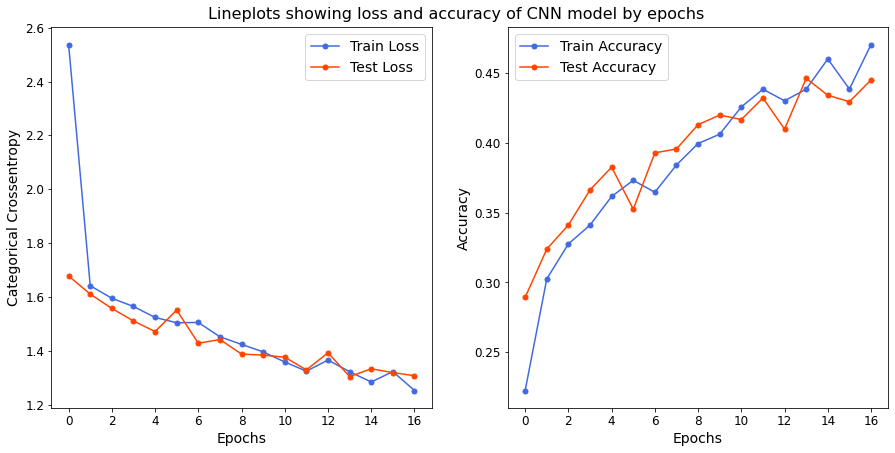

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/bal_cnn_1_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

bal_cnn_1_score = bal_cnn_1.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 2s 67ms/step - loss: 1.3078 - accuracy: 0.4452


In [ ]:
# Printing the relevant score summary.

bal_cnn_1_labels = bal_cnn_1.metrics_names
print(f'CNN_1 model {bal_cnn_1_labels[0]} \t= {round(bal_cnn_1_score[0], 3)}')
print(f'CNN_1 model {bal_cnn_1_labels[1]} \t= {round(bal_cnn_1_score[1], 3)}')

CNN_1 model loss 	= 1.308
CNN_1 model accuracy 	= 0.445


In [ ]:
# Generating predictions from the model above.

bal_cnn_1_pred = bal_cnn_1.predict(test_dataset)
bal_cnn_1_pred = bal_cnn_1_pred.argmax(axis=-1)

In [ ]:
len(bal_cnn_1_pred)

7113

In [ ]:
bal_cnn_1_cm = confusion_matrix(test_labels_list, bal_cnn_1_pred)
bal_cnn_1_cm

array([[734, 227,  14,  33,  13,   3],
       [ 35, 910,  78, 193,  46,   5],
       [ 14, 539, 151, 338,  75,   2],
       [ 20, 530, 144, 569, 186,   4],
       [ 29, 279,  58, 510, 599,  56],
       [ 27,  66,   3,  44, 375, 204]])

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/images/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


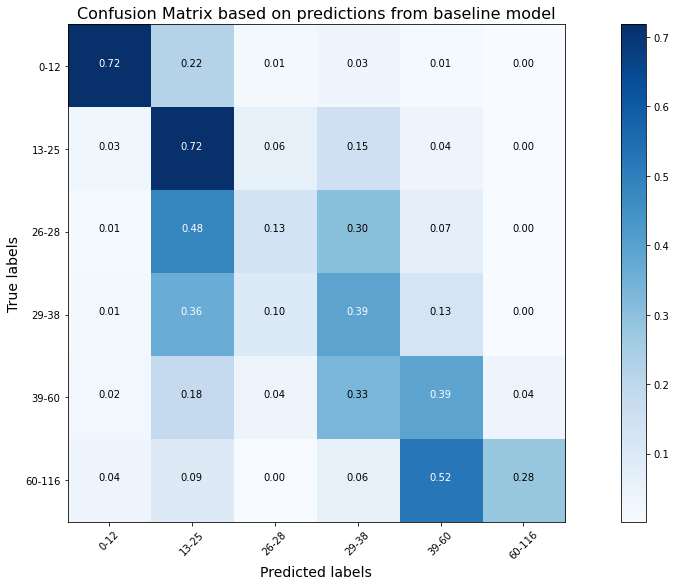

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-12','13-25','26-28','29-38','39-60','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bal_cnn_1_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="bin10_cnn_1_cm"
                     )

plt.show()

Confusion matrix, without normalization


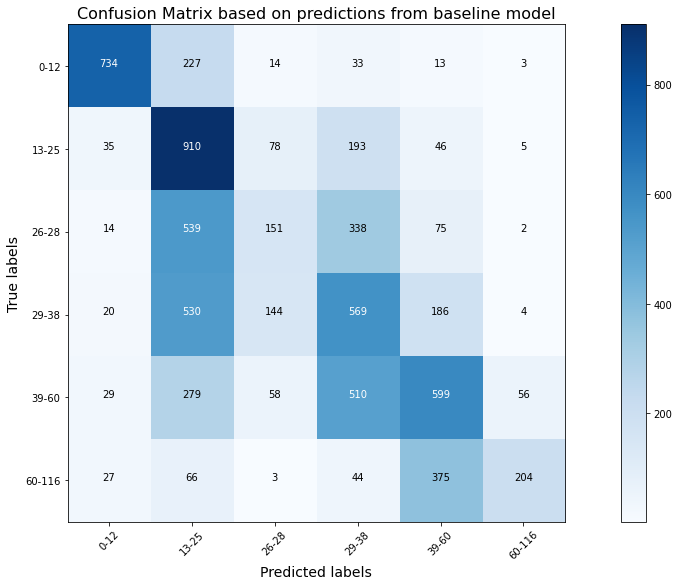

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-12','13-25','26-28','29-38','39-60','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bal_cnn_1_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="bin10_cnn_1_cm"
                     )

plt.show()

## CNN with Balanced Class (coloured images)

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_bal_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0    2389
1    2957
2    2611
3    3388
4    3572
5    1678
Name: age_bal_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.143962
1    0.178125
2    0.157318
3    0.204274
4    0.215240
5    0.101083
Name: age_bal_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
14303,/content/UTKFace/40_0_0_20170117134621935.jpg....,40
6075,/content/UTKFace/55_0_3_20170119205343062.jpg....,55
9634,/content/UTKFace/54_0_0_20170109012848473.jpg....,54
12156,/content/UTKFace/42_0_1_20170116205000015.jpg....,42
19249,/content/UTKFace/24_0_2_20170116161928019.jpg....,24


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 6

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

bal_cnn_2 = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
bal_cnn_2.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 3)))    # 3rd dim = 1 for grayscale images.
bal_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
bal_cnn_2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
bal_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

bal_cnn_2.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
bal_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

bal_cnn_2.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
bal_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
bal_cnn_2.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
bal_cnn_2.add(Dense(132, activation='relu'))

# Output layer with 6 nodes (equal to the no. of classes).
bal_cnn_2.add(Dense(6, activation='softmax'))

bal_cnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 average_pooling2d_4 (Averag  (None, 99, 99, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_5 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_6 (Averag  (None, 23, 23, 128)     

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Compiling the above created CNN architecture.

bal_cnn_2.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
    )

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the above created CNN model.

bal_cnn_2_history = bal_cnn_2.fit(train_dataset,
                                  batch_size=256,
                                  validation_data=test_dataset,
                                  epochs=30,
                                  callbacks=[early_stop],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/30
65/65 [==============================] - 13s 185ms/step - loss: 3.0523 - accuracy: 0.2354 - val_loss: 1.6789 - val_accuracy: 0.2816
Epoch 2/30
65/65 [==============================] - 12s 177ms/step - loss: 1.6558 - accuracy: 0.2965 - val_loss: 1.8462 - val_accuracy: 0.2099
Epoch 3/30
65/65 [==============================] - 12s 177ms/step - loss: 1.6392 - accuracy: 0.3070 - val_loss: 1.6026 - val_accuracy: 0.3332
Epoch 4/30
65/65 [==============================] - 12s 177ms/step - loss: 1.5972 - accuracy: 0.3259 - val_loss: 1.6137 - val_accuracy: 0.3335
Epoch 5/30
65/65 [==============================] - 12s 176ms/step - loss: 1.5445 - accuracy: 0.3519 - val_loss: 1.5430 - val_accuracy: 0.3520
Epoch 6/30
65/65 [==============================] - 12s 176ms/step - loss: 1.5383 - accuracy: 0.3525 - val_loss: 1.5232 - val_accuracy: 0.3657
Epoch 7/30
65/65 [==============================] - 12s 177ms/step - loss: 1.5591 - accuracy: 0.3502 - val_loss: 1.5400 - val_accuracy: 0.3554

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = bal_cnn_2_history.history['loss']
test_loss = bal_cnn_2_history.history['val_loss']
train_accuracy = bal_cnn_2_history.history['accuracy']
test_accuracy = bal_cnn_2_history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

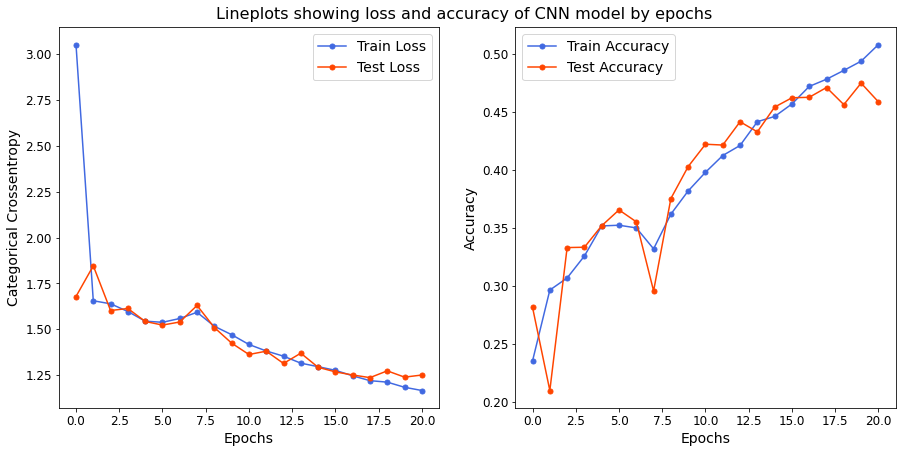

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

In [ ]:
# Evaluating the model on test dataset.

bal_cnn_2_score = bal_cnn_2.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 2s 82ms/step - loss: 1.2509 - accuracy: 0.4589


In [ ]:
# Printing the relevant score summary.

bal_cnn_2_labels = bal_cnn_2.metrics_names
print(f'CNN_1 model {bal_cnn_2_labels[0]} \t= {round(bal_cnn_2_score[0], 3)}')
print(f'CNN_1 model {bal_cnn_2_labels[1]} \t= {round(bal_cnn_2_score[1], 3)}')

CNN_1 model loss 	= 1.251
CNN_1 model accuracy 	= 0.459


In [ ]:
# Generating predictions from the model above.

bal_cnn_2_pred = bal_cnn_2.predict(test_dataset)
bal_cnn_2_pred = bal_cnn_2_pred.argmax(axis=-1)

In [ ]:
len(bal_cnn_2_pred)

7113

In [ ]:
bal_cnn_2_cm = confusion_matrix(test_labels_list, bal_cnn_2_pred)
bal_cnn_2_cm

array([[783,  85,  70,  49,  36,   1],
       [ 51, 365, 506, 279,  65,   1],
       [ 12, 115, 559, 352,  80,   1],
       [  9,  79, 518, 588, 256,   3],
       [  8,  24, 203, 463, 803,  30],
       [ 10,   3,  17,  51, 472, 166]])

Normalized confusion matrix


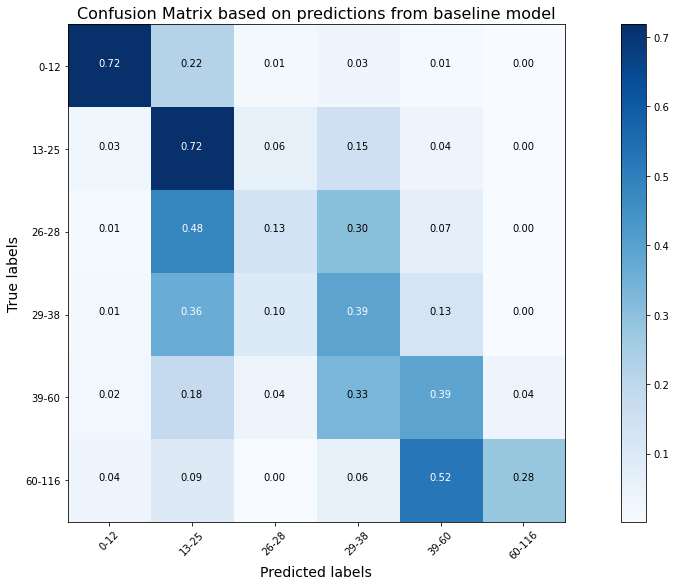

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-12','13-25','26-28','29-38','39-60','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bal_cnn_1_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="bal_cnn_2_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


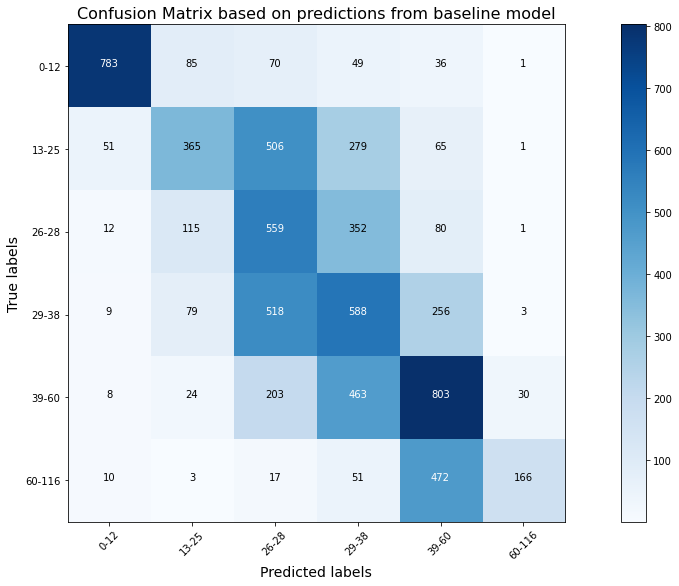

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-12','13-25','26-28','29-38','39-60','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bal_cnn_2_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="bal_cnn_2_cm"
                     )

plt.show()

## CNN with Intuition Class (grayscale images)

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_intuit_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0     786
1     731
2     872
3     826
4    8316
5    3181
6    1883
Name: age_intuit_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.047378
1    0.044004
2    0.052580
3    0.049768
4    0.501195
5    0.191621
6    0.113454
Name: age_intuit_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
4551,/content/UTKFace/9_0_0_20170110215523228.jpg.c...,9
15986,/content/UTKFace/5_0_3_20161220222937859.jpg.c...,5
21544,/content/UTKFace/25_1_0_20170116001327790.jpg....,25
20814,/content/UTKFace/30_1_2_20170116162552501.jpg....,30
20894,/content/UTKFace/29_1_2_20170104021748445.jpg....,29


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

intuit_cnn_1 = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
intuit_cnn_1.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
intuit_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
intuit_cnn_1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
intuit_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

intuit_cnn_1.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
intuit_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

intuit_cnn_1.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
intuit_cnn_1.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
intuit_cnn_1.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
intuit_cnn_1.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
intuit_cnn_1.add(Dense(7, activation='softmax'))

intuit_cnn_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_12 (Avera  (None, 99, 99, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_13 (Avera  (None, 48, 48, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_14 (Avera  (None, 23, 23, 128)     

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Compiling the above created CNN architecture.

intuit_cnn_1.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
    )

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the above created CNN model.

intuit_cnn_1_history = intuit_cnn_1.fit(train_dataset,
                                  batch_size=256,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[early_stop],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/60
65/65 [==============================] - 12s 178ms/step - loss: 1.9384 - accuracy: 0.4789 - val_loss: 1.4417 - val_accuracy: 0.5012
Epoch 2/60
65/65 [==============================] - 12s 177ms/step - loss: 1.3896 - accuracy: 0.5112 - val_loss: 1.3753 - val_accuracy: 0.5141
Epoch 3/60
65/65 [==============================] - 12s 178ms/step - loss: 1.3740 - accuracy: 0.5151 - val_loss: 1.4070 - val_accuracy: 0.4933
Epoch 4/60
65/65 [==============================] - 12s 178ms/step - loss: 1.3268 - accuracy: 0.5265 - val_loss: 1.2796 - val_accuracy: 0.5382
Epoch 5/60
65/65 [==============================] - 12s 178ms/step - loss: 1.2545 - accuracy: 0.5408 - val_loss: 1.2496 - val_accuracy: 0.5223
Epoch 6/60
65/65 [==============================] - 12s 178ms/step - loss: 1.2724 - accuracy: 0.5322 - val_loss: 1.3078 - val_accuracy: 0.5065
Epoch 7/60
65/65 [==============================] - 12s 178ms/step - loss: 1.2251 - accuracy: 0.5450 - val_loss: 1.2284 - val_accuracy: 0.5483

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = intuit_cnn_1_history.history['loss']
test_loss = intuit_cnn_1_history.history['val_loss']
train_accuracy = intuit_cnn_1_history.history['accuracy']
test_accuracy = intuit_cnn_1_history.history['val_accuracy']

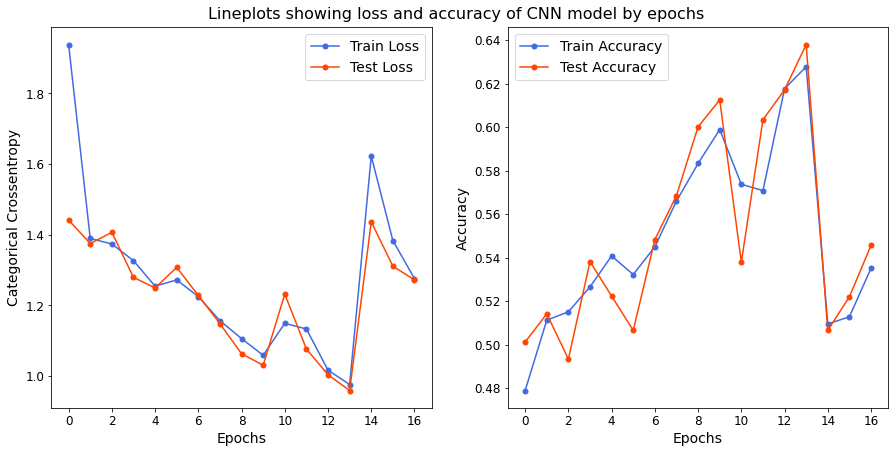

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/intuit_cnn_1_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

intuit_cnn_1_score = intuit_cnn_1.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 2s 68ms/step - loss: 1.2723 - accuracy: 0.5456


In [ ]:
# Printing the relevant score summary.

intuit_cnn_1_labels = intuit_cnn_1.metrics_names
print(f'CNN_1 model {intuit_cnn_1_labels[0]} \t= {round(intuit_cnn_1_score[0], 3)}')
print(f'CNN_1 model {intuit_cnn_1_labels[1]} \t= {round(intuit_cnn_1_score[1], 3)}')

CNN_1 model loss 	= 1.272
CNN_1 model accuracy 	= 0.546


In [ ]:
# Generating predictions from the model above.

intuit_cnn_1_pred = intuit_cnn_1.predict(test_dataset)
intuit_cnn_1_pred = intuit_cnn_1_pred.argmax(axis=-1)

In [ ]:
len(intuit_cnn_1_pred)

7113

In [ ]:
intuit_cnn_1_cm = confusion_matrix(test_labels_list, intuit_cnn_1_pred)
intuit_cnn_1_cm

array([[ 255,    2,   14,    0,   52,   11,    3],
       [ 162,    2,   35,    0,   87,   23,    4],
       [  58,    0,   80,    6,  178,   17,   35],
       [   6,    0,   39,   15,  230,   21,   43],
       [  50,    2,   34,   17, 3153,  187,  122],
       [  24,    4,   26,    6,  993,  175,  135],
       [  14,    2,   42,    2,  391,  155,  201]])

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/images/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


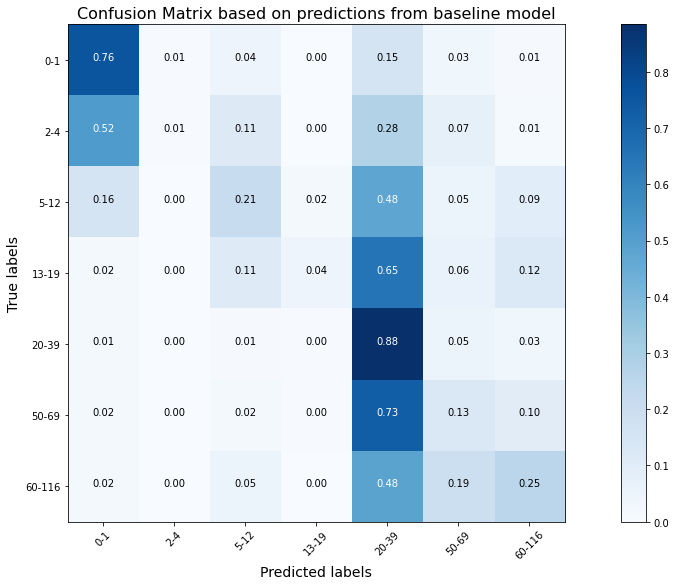

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(intuit_cnn_1_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="intuit_cnn_1_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


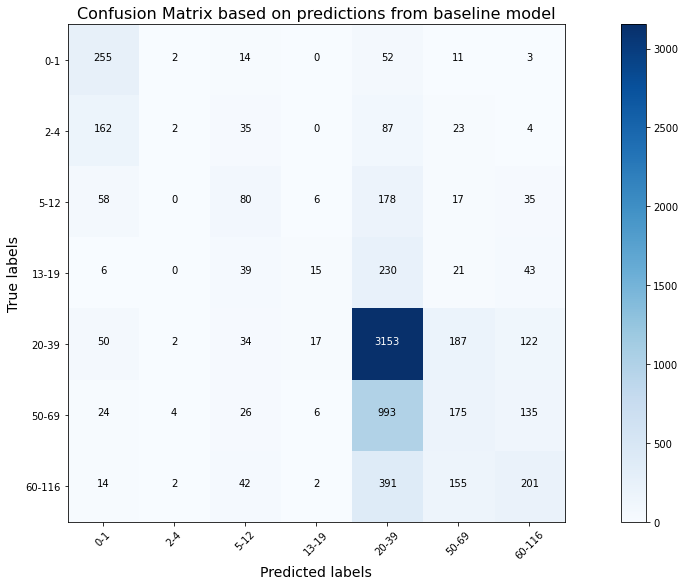

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(intuit_cnn_1_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="intuit_cnn_1_cm"
                     )

plt.show()

## CNN with Intuition Class (coloured images)

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_intuit_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0     786
1     731
2     872
3     826
4    8316
5    3181
6    1883
Name: age_intuit_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.047378
1    0.044004
2    0.052580
3    0.049768
4    0.501195
5    0.191621
6    0.113454
Name: age_intuit_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
4551,/content/UTKFace/9_0_0_20170110215523228.jpg.c...,9
15986,/content/UTKFace/5_0_3_20161220222937859.jpg.c...,5
21544,/content/UTKFace/25_1_0_20170116001327790.jpg....,25
20814,/content/UTKFace/30_1_2_20170116162552501.jpg....,30
20894,/content/UTKFace/29_1_2_20170104021748445.jpg....,29


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# Defining the architecture of the sequential neural network.

intuit_cnn_2 = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
intuit_cnn_2.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 3)))    # 3rd dim = 1 for grayscale images.
intuit_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
intuit_cnn_2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
intuit_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

intuit_cnn_2.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
intuit_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

intuit_cnn_2.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
intuit_cnn_2.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
intuit_cnn_2.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
intuit_cnn_2.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
intuit_cnn_2.add(Dense(7, activation='softmax'))

intuit_cnn_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 average_pooling2d_16 (Avera  (None, 99, 99, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_17 (Avera  (None, 48, 48, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_18 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_18 (Avera  (None, 23, 23, 128)     

In [ ]:
# Testing to ensure GPU is being utilized.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Compiling the above created CNN architecture.

intuit_cnn_2.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy']
    )

In [ ]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

In [ ]:
# Fitting the above created CNN model.

intuit_cnn_2_history = intuit_cnn_2.fit(train_dataset,
                                  batch_size=256,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[early_stop],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/60
65/65 [==============================] - 12s 178ms/step - loss: 3.0257 - accuracy: 0.4602 - val_loss: 1.4822 - val_accuracy: 0.5012
Epoch 2/60
65/65 [==============================] - 11s 176ms/step - loss: 1.4502 - accuracy: 0.5011 - val_loss: 1.5180 - val_accuracy: 0.5012
Epoch 3/60
65/65 [==============================] - 11s 176ms/step - loss: 1.3984 - accuracy: 0.5046 - val_loss: 1.3244 - val_accuracy: 0.5209
Epoch 4/60
65/65 [==============================] - 11s 175ms/step - loss: 1.4654 - accuracy: 0.4994 - val_loss: 1.4566 - val_accuracy: 0.5012
Epoch 5/60
65/65 [==============================] - 12s 176ms/step - loss: 1.4078 - accuracy: 0.5090 - val_loss: 1.3542 - val_accuracy: 0.5189
Epoch 6/60
65/65 [==============================] - 12s 176ms/step - loss: 1.3216 - accuracy: 0.5271 - val_loss: 1.3107 - val_accuracy: 0.5317
Epoch 7/60
65/65 [==============================] - 12s 176ms/step - loss: 1.2701 - accuracy: 0.5393 - val_loss: 1.2417 - val_accuracy: 0.5480

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = intuit_cnn_2_history.history['loss']
test_loss = intuit_cnn_2_history.history['val_loss']
train_accuracy = intuit_cnn_2_history.history['accuracy']
test_accuracy = intuit_cnn_2_history.history['val_accuracy']

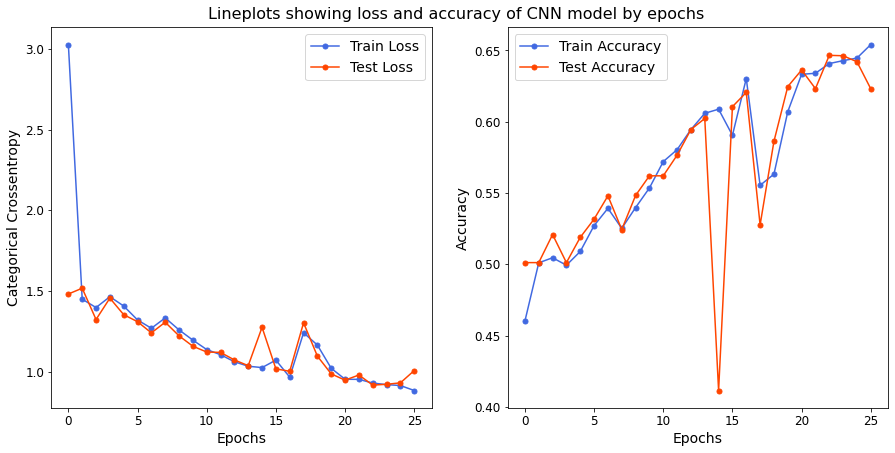

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/intuit_cnn_2_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

intuit_cnn_2_score = intuit_cnn_2.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 2s 82ms/step - loss: 1.0085 - accuracy: 0.6231


In [ ]:
# Printing the relevant score summary.

intuit_cnn_2_labels = intuit_cnn_2.metrics_names
print(f'CNN_2 model {intuit_cnn_2_labels[0]} \t= {round(intuit_cnn_2_score[0], 3)}')
print(f'CNN_2 model {intuit_cnn_2_labels[1]} \t= {round(intuit_cnn_2_score[1], 3)}')

CNN_2 model loss 	= 1.009
CNN_2 model accuracy 	= 0.623


In [ ]:
# Generating predictions from the model above.

intuit_cnn_2_pred = intuit_cnn_2.predict(test_dataset)
intuit_cnn_2_pred = intuit_cnn_2_pred.argmax(axis=-1)

In [ ]:
len(intuit_cnn_2_pred)

7113

In [ ]:
intuit_cnn_2_cm = confusion_matrix(test_labels_list, intuit_cnn_2_pred)
intuit_cnn_2_cm

array([[ 286,   39,    2,    0,   10,    0,    0],
       [ 147,  108,   30,    0,   26,    0,    2],
       [  17,   56,  159,    2,  133,    4,    3],
       [   4,    7,   66,   12,  254,    4,    7],
       [   8,   18,   30,    5, 3431,   54,   19],
       [   3,   11,   28,    1, 1085,  148,   87],
       [   9,   12,   42,    2,  377,   77,  288]])

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/Colab Notebooks/images/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


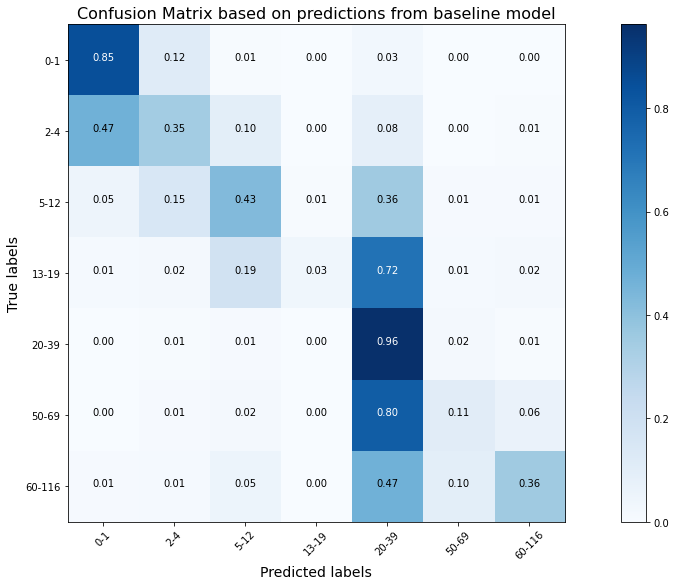

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(intuit_cnn_2_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="intuit_cnn_2_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


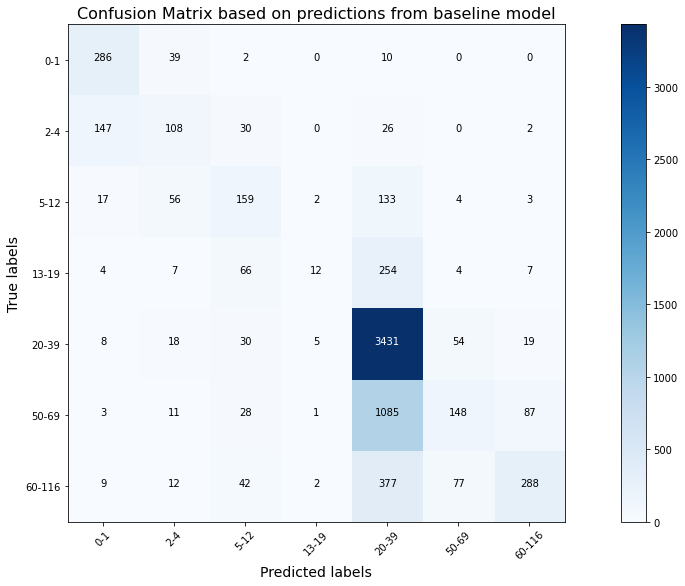

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(intuit_cnn_2_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from baseline model",
                      export_as="intuit_cnn_2_cm"
                     )

plt.show()

# VGG16 Model

## VGG16 with Bin10 Class (coloured images)

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_bin10_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0    2143
1    1072
2    5141
3    3176
4    1571
5    1609
6     923
7     489
8     353
9     118
Name: age_bin10_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.129200
1    0.064530
2    0.309715
3    0.191340
4    0.094756
5    0.097005
6    0.055532
7    0.029523
8    0.021229
9    0.007170
Name: age_bin10_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
16216,/content/UTKFace/1_1_2_20161219203318222.jpg.c...,1
14501,/content/UTKFace/10_0_0_20170110224500062.jpg....,10
2573,/content/UTKFace/25_1_4_20161221193646742.jpg....,25
17687,/content/UTKFace/2_0_4_20161221192650388.jpg.c...,2
553,/content/UTKFace/36_1_0_20170105183405999.jpg....,36


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 10

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# VGG16 base model
bin10_vgg16_2 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (200, 200, 3)
    )
bin10_vgg16_2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in bin10_vgg16_2.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = bin10_vgg16_2.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax', name='predictions')(x)
bin10_vgg16_2 = tf.keras.Model(bin10_vgg16_2.input, x)
# We compile the model
bin10_vgg16_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
bin10_vgg16_2.summary()

Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fitting the model.

bin10_vgg16_2_history = bin10_vgg16_2.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 35s 542ms/step - loss: 0.7645 - accuracy: 0.6870 - val_loss: 1.4450 - val_accuracy: 0.5123
Epoch 2/30
65/65 [==============================] - 35s 544ms/step - loss: 0.7201 - accuracy: 0.7094 - val_loss: 1.4593 - val_accuracy: 0.5081
Epoch 3/30
65/65 [==============================] - 35s 543ms/step - loss: 0.6612 - accuracy: 0.7329 - val_loss: 1.4924 - val_accuracy: 0.5113
Epoch 4/30
65/65 [==============================] - 35s 544ms/step - loss: 0.6282 - accuracy: 0.7445 - val_loss: 1.6350 - val_accuracy: 0.5089
Epoch 5/30
65/65 [==============================] - 35s 544ms/step - loss: 0.5859 - accuracy: 0.7650 - val_loss: 1.6740 - val_accuracy: 0.5143
Epoch 6/30
65/65 [==============================] - 35s 543ms/step - loss: 0.5578 - accuracy: 0.7730 - val_loss: 1.7164 - val_accuracy: 0.4928
Epoch 7/30
65/65 [==============================] - 35s 544ms/step - loss: 0.5378 - accuracy: 0.7831 - val_loss: 1.7357 - val_accuracy: 0.4975

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = bin10_vgg16_2_history.history['loss']
test_loss = bin10_vgg16_2_history.history['val_loss']
train_accuracy = bin10_vgg16_2_history.history['accuracy']
test_accuracy = bin10_vgg16_2_history.history['val_accuracy']

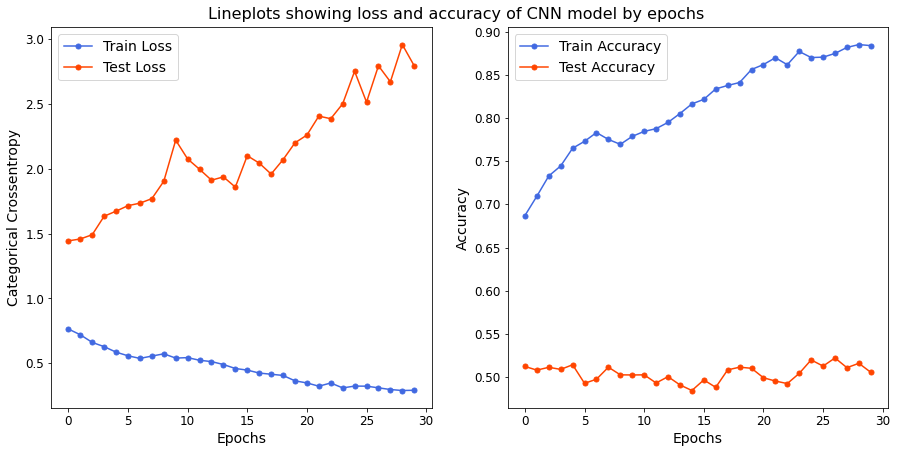

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/bin10_vgg16_2_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

bin10_vgg16_2_score = bin10_vgg16_2.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 11s 372ms/step - loss: 2.7957 - accuracy: 0.5056


In [ ]:
# Printing the relevant score summary.

bin10_vgg16_2_labels = bin10_vgg16_2.metrics_names
print(f'bin10_vgg16_2 model {bin10_vgg16_2_labels[0]} \t= {round(bin10_vgg16_2_score[0], 3)}')
print(f'bin10_vgg16_2 model {bin10_vgg16_2_labels[1]} \t= {round(bin10_vgg16_2_score[1], 3)}')

bin10_vgg16_2 model loss 	= 2.796
bin10_vgg16_2 model accuracy 	= 0.506


In [ ]:
# Generating predictions from the model above.

bin10_vgg16_2_pred = bin10_vgg16_2.predict(test_dataset)
bin10_vgg16_2_pred = bin10_vgg16_2_pred.argmax(axis=-1)

In [ ]:
len(bin10_vgg16_2_pred)

7113

In [ ]:
bin10_vgg16_2_cm = confusion_matrix(test_labels_list, bin10_vgg16_2_pred)
bin10_vgg16_2_cm

array([[ 767,   79,   55,   13,    3,    2,    0,    0,    0,    0],
       [  51,  162,  192,   42,    5,    2,    3,    2,    0,    0],
       [  17,   58, 1652,  391,   51,   30,    2,    1,    1,    0],
       [   8,   25,  686,  444,  113,   71,   10,    0,    4,    0],
       [   7,    8,  187,  203,  112,  133,   16,    4,    4,    0],
       [   3,    3,   97,   93,  105,  293,   57,   25,   14,    0],
       [   3,    7,   33,   25,   25,  165,   67,   51,   19,    0],
       [   0,    1,    7,    5,    6,   80,   38,   40,   32,    1],
       [   1,    1,    3,    2,    5,   23,   27,   32,   57,    0],
       [   0,    0,    0,    0,    2,    5,    5,    9,   28,    2]])

Normalized confusion matrix


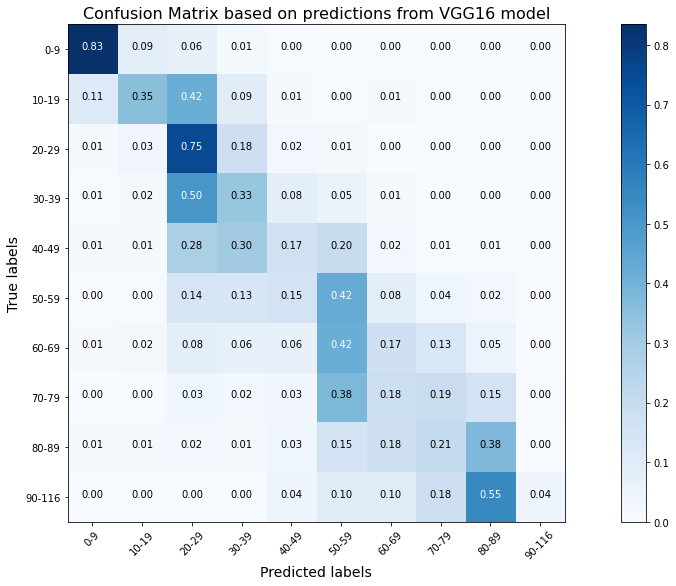

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bin10_vgg16_2_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="bin10_vgg16_2_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


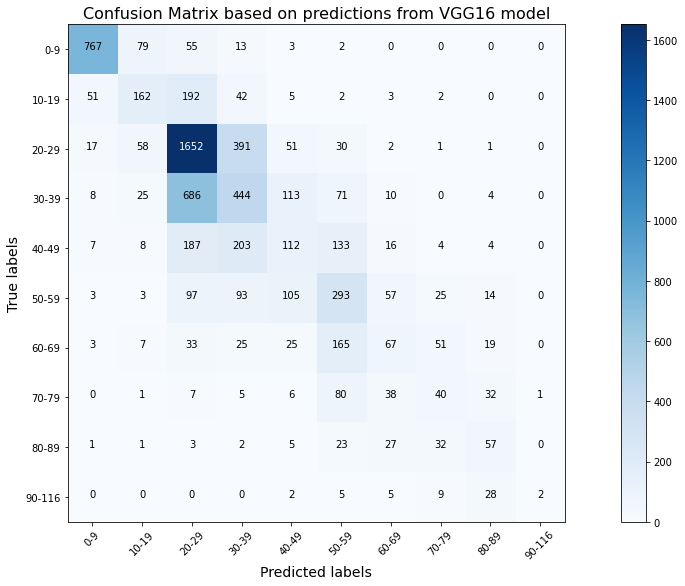

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bin10_vgg16_2_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="bin10_vgg16_2_cm"
                     )

plt.show()

## VGG16 with Balanced Class (coloured images)

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_bal_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0    2389
1    2957
2    2611
3    3388
4    3572
5    1678
Name: age_bal_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.143962
1    0.178125
2    0.157318
3    0.204274
4    0.215240
5    0.101083
Name: age_bal_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
14303,/content/UTKFace/40_0_0_20170117134621935.jpg....,40
6075,/content/UTKFace/55_0_3_20170119205343062.jpg....,55
9634,/content/UTKFace/54_0_0_20170109012848473.jpg....,54
12156,/content/UTKFace/42_0_1_20170116205000015.jpg....,42
19249,/content/UTKFace/24_0_2_20170116161928019.jpg....,24


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 6

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# VGG16 base model
bal_vgg16_2 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (200, 200, 3)
    )
bal_vgg16_2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in bal_vgg16_2.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = bal_vgg16_2.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(6, activation='softmax', name='predictions')(x)
bal_vgg16_2 = tf.keras.Model(bal_vgg16_2.input, x)
# We compile the model
bal_vgg16_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
bal_vgg16_2.summary()

Layer input_5 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                  

In [ ]:
# Fitting the model.

bal_vgg16_2_history = bal_vgg16_2.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 36s 540ms/step - loss: 13.5818 - accuracy: 0.3660 - val_loss: 1.2315 - val_accuracy: 0.4731
Epoch 2/30
65/65 [==============================] - 35s 540ms/step - loss: 1.2280 - accuracy: 0.4684 - val_loss: 1.1340 - val_accuracy: 0.5158
Epoch 3/30
65/65 [==============================] - 35s 542ms/step - loss: 1.0826 - accuracy: 0.5314 - val_loss: 1.0998 - val_accuracy: 0.5259
Epoch 4/30
65/65 [==============================] - 35s 542ms/step - loss: 0.9886 - accuracy: 0.5670 - val_loss: 1.0813 - val_accuracy: 0.5385
Epoch 5/30
65/65 [==============================] - 35s 543ms/step - loss: 0.8987 - accuracy: 0.6080 - val_loss: 1.1037 - val_accuracy: 0.5392
Epoch 6/30
65/65 [==============================] - 35s 543ms/step - loss: 0.8432 - accuracy: 0.6306 - val_loss: 1.1186 - val_accuracy: 0.5403
Epoch 7/30
65/65 [==============================] - 35s 543ms/step - loss: 0.7840 - accuracy: 0.6549 - val_loss: 1.1453 - val_accuracy: 0.538

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = bal_vgg16_2_history.history['loss']
test_loss = bal_vgg16_2_history.history['val_loss']
train_accuracy = bal_vgg16_2_history.history['accuracy']
test_accuracy = bal_vgg16_2_history.history['val_accuracy']

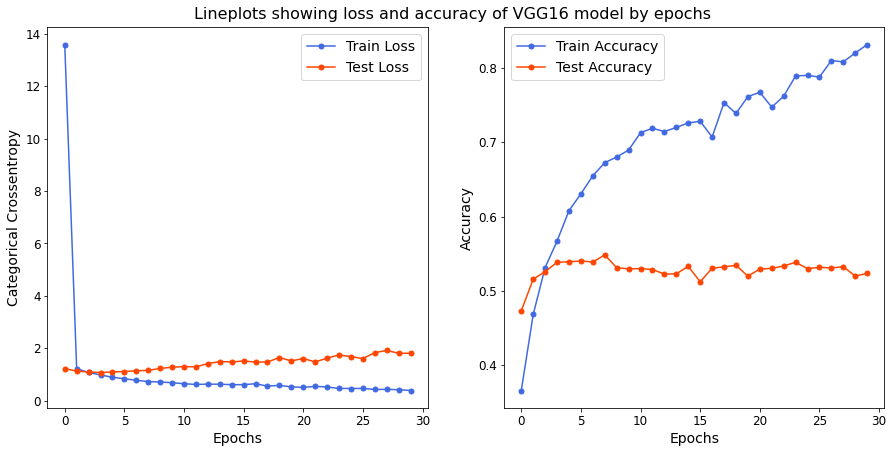

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/bal_vgg16_2_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

bal_vgg16_2_score = bal_vgg16_2.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 11s 376ms/step - loss: 1.8146 - accuracy: 0.5235


In [ ]:
# Printing the relevant score summary.

bal_vgg16_2_labels = bal_vgg16_2.metrics_names
print(f'bal_vgg16_2 model {bal_vgg16_2_labels[0]} \t= {round(bal_vgg16_2_score[0], 3)}')
print(f'bal_vgg16_2 model {bal_vgg16_2_labels[1]} \t= {round(bal_vgg16_2_score[1], 3)}')

bal_vgg16_2 model loss 	= 1.815
bal_vgg16_2 model accuracy 	= 0.524


In [ ]:
# Generating predictions from the model above.

bal_vgg16_2_pred = bal_vgg16_2.predict(test_dataset)
bal_vgg16_2_pred = bal_vgg16_2_pred.argmax(axis=-1)

In [ ]:
len(bal_vgg16_2_pred)

7113

In [ ]:
bal_vgg16_2_cm = confusion_matrix(test_labels_list, bal_vgg16_2_pred)
bal_vgg16_2_cm

array([[845, 115,  34,  20,   6,   4],
       [ 53, 554, 275, 341,  40,   4],
       [  7, 252, 357, 423,  76,   4],
       [  8, 175, 323, 689, 247,  11],
       [  5,  52, 103, 415, 808, 148],
       [  2,   1,   7,  20, 218, 471]])

Normalized confusion matrix


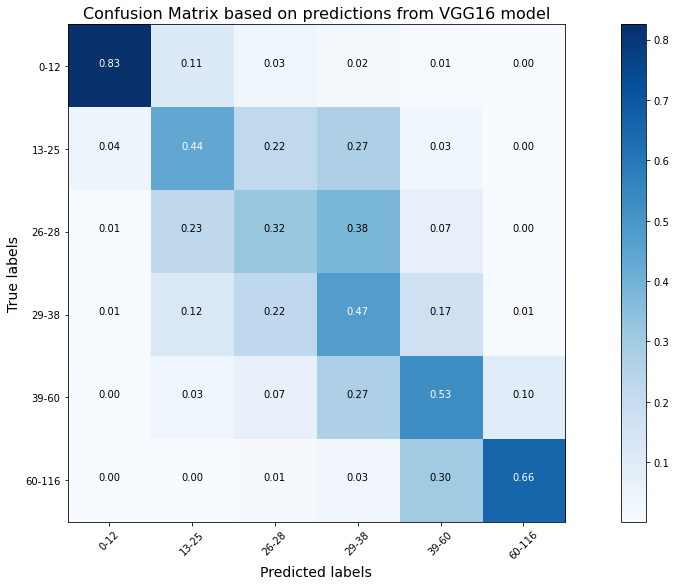

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-12','13-25','26-28','29-38','39-60','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bal_vgg16_2_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="bal_vgg16_2_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


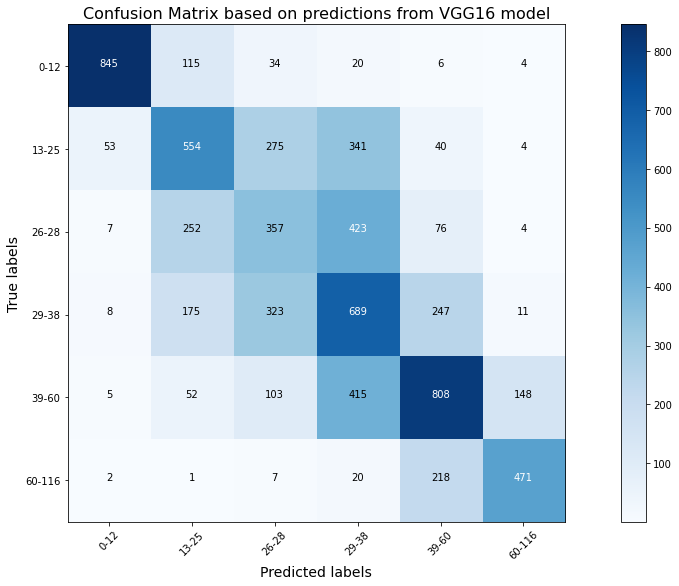

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-12','13-25','26-28','29-38','39-60','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(bal_vgg16_2_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="bal_vgg16_2_cm"
                     )

plt.show()

## VGG16 with Intuition Class (coloured images)

In [ ]:
# Defining the filenames and ages as X and target y for train test split

X = df_images[['filename','age']]
y = df_images['age_intuit_class']

# Do a train test split with test_size =0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Check the distribution of y_train
y_train.value_counts().sort_index()

0     786
1     731
2     872
3     826
4    8316
5    3181
6    1883
Name: age_intuit_class, dtype: int64

In [ ]:
# Check the distribution of y_test
y_test.value_counts(normalize=True).sort_index()

0    0.047378
1    0.044004
2    0.052580
3    0.049768
4    0.501195
5    0.191621
6    0.113454
Name: age_intuit_class, dtype: float64

In [ ]:
X_train.head()

,filename,age
4551,/content/UTKFace/9_0_0_20170110215523228.jpg.c...,9
15986,/content/UTKFace/5_0_3_20161220222937859.jpg.c...,5
21544,/content/UTKFace/25_1_0_20170116001327790.jpg....,25
20814,/content/UTKFace/30_1_2_20170116162552501.jpg....,30
20894,/content/UTKFace/29_1_2_20170104021748445.jpg....,29


In [ ]:
# Converting the filenames and target class labels into lists for both train and test datasets.

train_filenames_list = list(X_train['filename'])
train_labels_list = list(y_train)

test_filenames_list = list(X_test['filename'])
test_labels_list = list(y_test)

In [ ]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
# VGG16 base model
intuit_vgg16_2 = VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape= (200, 200, 3)
    )
intuit_vgg16_2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in intuit_vgg16_2.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = intuit_vgg16_2.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(7, activation='softmax', name='predictions')(x)
intuit_vgg16_2 = tf.keras.Model(intuit_vgg16_2.input, x)
# We compile the model
intuit_vgg16_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
intuit_vgg16_2.summary()

Layer input_8 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                  

In [ ]:
# Fitting the model.

intuit_vgg16_2_history = intuit_vgg16_2.fit(train_dataset,
                        batch_size=256,
                        validation_data=test_dataset,
                        epochs=30,
                        shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                       )

Epoch 1/30
65/65 [==============================] - 36s 541ms/step - loss: 18.7399 - accuracy: 0.5318 - val_loss: 0.9267 - val_accuracy: 0.6553
Epoch 2/30
65/65 [==============================] - 35s 540ms/step - loss: 0.8579 - accuracy: 0.6693 - val_loss: 0.8240 - val_accuracy: 0.6928
Epoch 3/30
65/65 [==============================] - 35s 544ms/step - loss: 0.6608 - accuracy: 0.7384 - val_loss: 0.8037 - val_accuracy: 0.7021
Epoch 4/30
65/65 [==============================] - 35s 542ms/step - loss: 0.5345 - accuracy: 0.7848 - val_loss: 0.8106 - val_accuracy: 0.7014
Epoch 5/30
65/65 [==============================] - 35s 543ms/step - loss: 0.4430 - accuracy: 0.8242 - val_loss: 0.8431 - val_accuracy: 0.6975
Epoch 6/30
65/65 [==============================] - 35s 543ms/step - loss: 0.3595 - accuracy: 0.8570 - val_loss: 0.9048 - val_accuracy: 0.6990
Epoch 7/30
65/65 [==============================] - 35s 544ms/step - loss: 0.3186 - accuracy: 0.8744 - val_loss: 0.9242 - val_accuracy: 0.708

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = intuit_vgg16_2_history.history['loss']
test_loss = intuit_vgg16_2_history.history['val_loss']
train_accuracy = intuit_vgg16_2_history.history['accuracy']
test_accuracy = intuit_vgg16_2_history.history['val_accuracy']

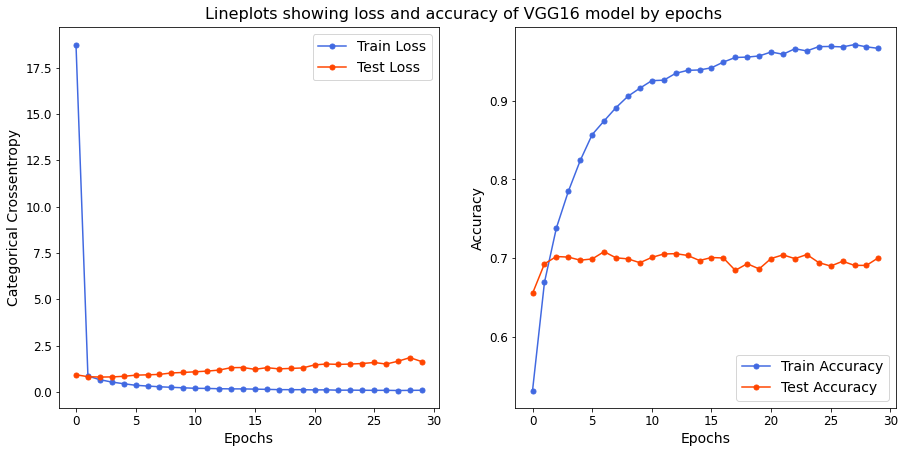

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of VGG16 model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/intuit_vgg16_2_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# Evaluating the model on test dataset.

intuit_vgg16_2_score = intuit_vgg16_2.evaluate(test_dataset, verbose=1)

28/28 [==============================] - 11s 373ms/step - loss: 1.6335 - accuracy: 0.7005


In [ ]:
# Printing the relevant score summary.

intuit_vgg16_2_labels = intuit_vgg16_2.metrics_names
print(f'intuit_vgg16_2 model {intuit_vgg16_2_labels[0]} \t= {round(intuit_vgg16_2_score[0], 3)}')
print(f'intuit_vgg16_2 model {intuit_vgg16_2_labels[1]} \t= {round(intuit_vgg16_2_score[1], 3)}')

intuit_vgg16_2 model loss 	= 1.634
intuit_vgg16_2 model accuracy 	= 0.701


In [ ]:
# Generating predictions from the model above.

intuit_vgg16_2_pred = intuit_vgg16_2.predict(test_dataset)
intuit_vgg16_2_pred = intuit_vgg16_2_pred.argmax(axis=-1)

In [ ]:
len(intuit_vgg16_2_pred)

7113

In [ ]:
intuit_vgg16_2_cm = confusion_matrix(test_labels_list, intuit_vgg16_2_pred)
intuit_vgg16_2_cm

array([[ 259,   70,    4,    1,    2,    0,    1],
       [  85,  164,   51,    2,   10,    0,    1],
       [   6,   55,  179,   55,   68,    9,    2],
       [   1,    0,   66,   86,  187,   11,    3],
       [   2,    8,   39,   59, 3068,  374,   15],
       [   0,    0,    7,    5,  493,  734,  124],
       [   0,    0,    1,    4,   67,  242,  493]])

Normalized confusion matrix


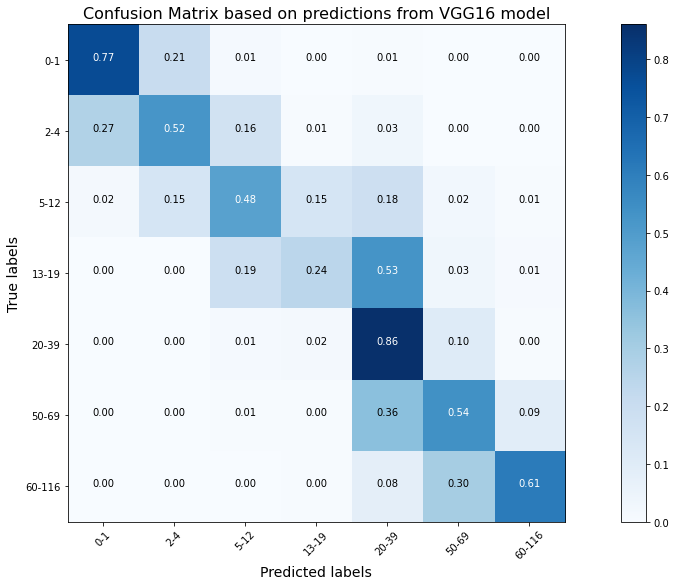

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(intuit_vgg16_2_cm, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="intuit_vgg16_2_cm_normalized"
                     )

plt.show()

Confusion matrix, without normalization


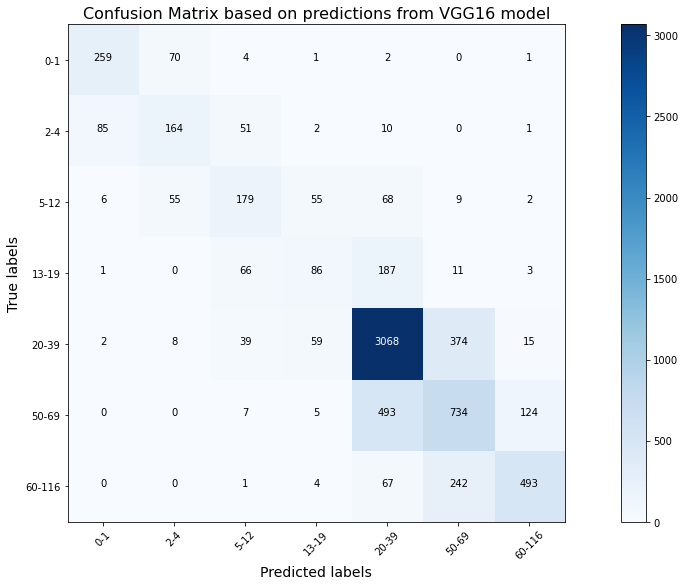

In [ ]:
# Plotting the NORMALIZED confusion matrix using the function defined above.

cm_plot_labels = ['0-1','2-4','5-12','13-19','20-39','50-69','60-116']


plt.figure(figsize=(16,8))
plot_confusion_matrix(intuit_vgg16_2_cm, cm_plot_labels, normalize=False,
                      title="Confusion Matrix based on predictions from VGG16 model",
                      export_as="intuit_vgg16_2_cm"
                     )

plt.show()

# Evaluating Models and Dataset

|Model|Dataset|Images|Epochs|Train_Loss|Test_Loss|Train_Acc|Test_Acc| 
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
Base CNN|Bin10|Gray|14 of 30|1.7111|1.6766|38.20%|38.68%
Base CNN|Bin10|Color|30 of 30|1.3527|1.4037|47.06%|45.40%
Base CNN|Balance|Gray|17 of 30|1.2528|1.307|47.06%|44.52%
Base CNN|Balance|Color|21 of 30|1.1665|1.2509|50.83%|45.89%
Base CNN|Intuition|Gray|17 of 30|1.2762|1.2723|53.21%|54.56%
Base CNN|Intuition|Color|26 of 30|0.8850|1.0085|65.41%|62.31%
VGG16|Bin10|Color|30 of 30|0.2917|2.7957|88.50%|51.60%
VGG16|Balance|Color|30 of 30|0.3951|1.8146|83.13%|52.35%
VGG16|Intuition|Color|30 of 30|0.0907|1.6325|96.66%|70.05%


Above shows the evaluation for all the models thus far. The VGG16 model with Intuition Classified dataset had the highest accuracy, yet it was extremely overfitted.
